In [1]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee


In this notebook I set znot as a constant to get rid of the correlation between znot and tau. I set it to the average recieved from the previous codes. 

Mira

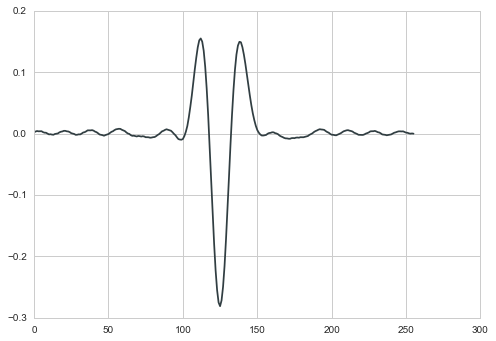

In [4]:
file=open( '../../../data/raw_data/20160707_1940_x_mirror_1in_aperture.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(D)

It must be noted again that the plot is already very symmetric. therefore tau may not play a large role. 

In [5]:
#model function convoluted with RC circuit and AC coupling function
def psi1(q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    znot = -.016
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

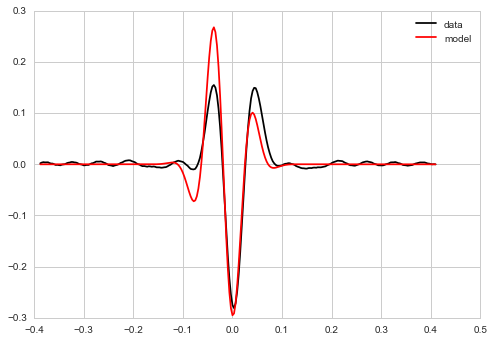

In [6]:
pl.plot(t,D, color = 'black', label = 'data')
t,Model = psi1(9.4,0.035, 0.001)
pl.plot(t,Model*.0005, color = 'red', label = 'model')
pl.legend()

In [7]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    q, p, T, a = params 
    t,Modelf = psi1(q,p, T)
    Dev = -.5*(np.dot((D-Modelf*a),D-Modelf*a))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [8]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [8.57, .05, .02, .0002], args=(t,D))
q1,p1,T1,a1 = result["x"]
#print result ["x"]

In [9]:
#prior function
#again, why is it ln?
def lnprior(params):
    q, p, T, a = params 
    if 5.0 < q < 15.0 and .01 < p < .1 and 0 < T < 0.1 and 0.0 < a < .0009:
        return 0.0
    return -np.inf 
    #set znot to some delay because then tau  must move to accomodate as opposed to znot doing so. 
    #center znot at zero. (-.00001<z<.000001)
    #

In [10]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

In [11]:
ndim, nwalkers = 4,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [12]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

In [13]:
sampler.run_mcmc(pos, 5000); #number of steps

(260, 5000, 4)


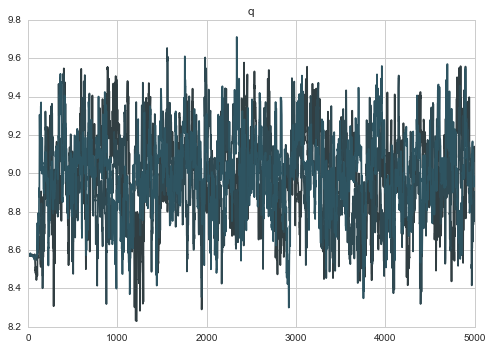

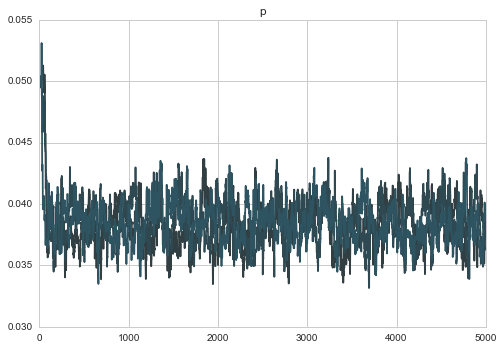

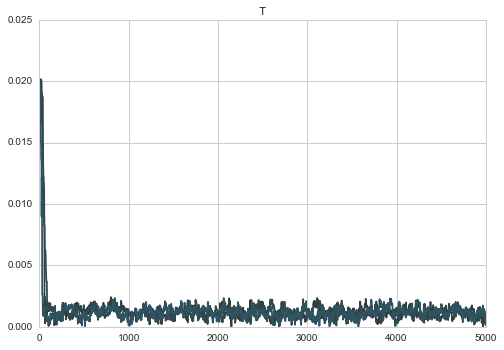

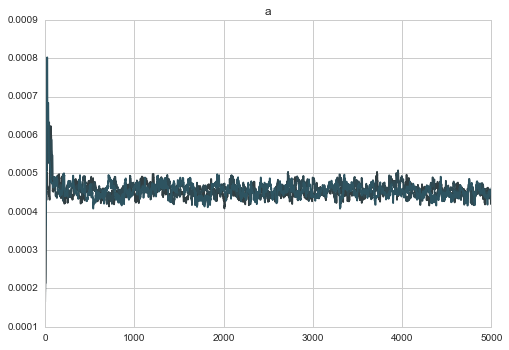

In [14]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[0,:,nn])
    pl.plot(walks[1,:,nn])
    pl.plot(walks[2,:,nn])
    titles = ['q','p','T','a']
    pl.title(titles[nn])
    pl.show() #sigma = .001

These are the 5000 steps of three of the walkers. 

In [15]:
samples = sampler.chain[:,1000:,:].reshape([-1, ndim])
print(np.shape(samples)) #treating all walkers as experiments
batman=sampler.chain[:,1000:,:]
print(np.shape(batman))
#5: number of variables, 3000: number of data points/experiments run, 260: number of walkers

(1040000, 4)
(260, 4000, 4)


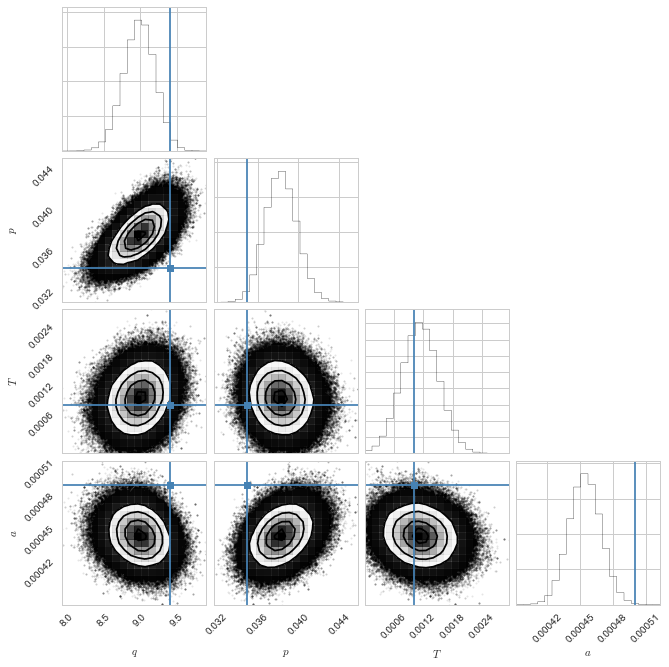

In [16]:
import corner
fig = corner.corner(samples, labels=["$q$", "$p$", "$T$", "$a$"], 
                    truths=[9.4, .035, .001, .0005]) #znot: -.02
fig.savefig("MCMCattempt2.png")

without znot tau is not correlated and the plots are all circular. 
However it has been suggested that tau is so small because we are not using scan speeds that are high enough. therefore the following analysis may be irrelevent. 
I will show it anyway. 

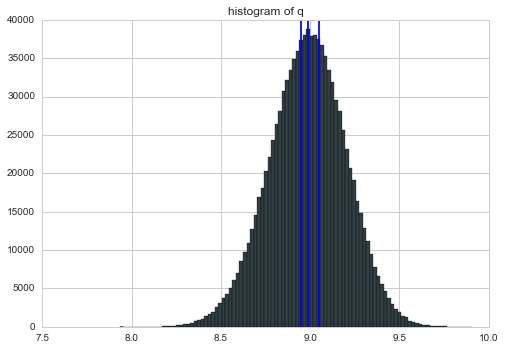

the mean is:  8.98586740778


In [20]:
#histogram of q
pl.hist(samples[:,0], 100,)
pl.title('histogram of q')

pl.axvline(x = 8.9884355587944622)
pl.axvline(x = 8.95)
pl.axvline(x = 9.05)
pl.show()
print 'the mean is: ', np.mean(samples[:,0])

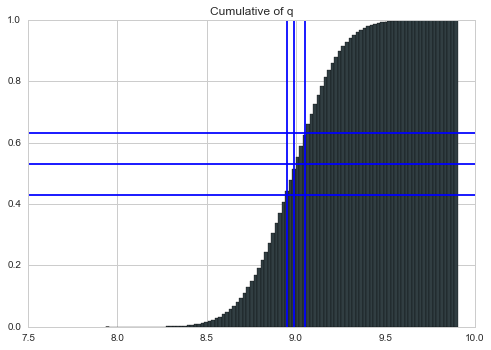

In [18]:
#cumulative plot of q
pl.hist(samples[:,0], 100, normed = 1,  cumulative = True)

pl.axvline(x = 8.9884355587944622)
pl.axhline(y = .43)
pl.axhline(y = .53)
pl.axhline(y = .63)

pl.axvline(x = 8.95)
pl.axvline(x = 9.05)
pl.title('Cumulative of q')
pl.show()



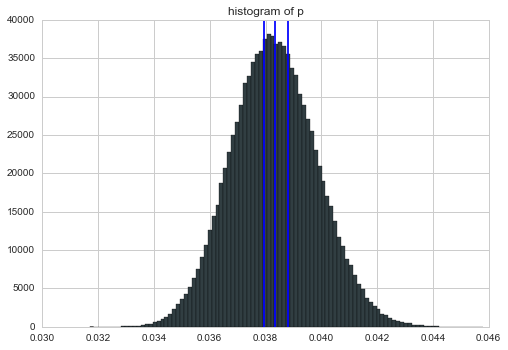

the mean is:  0.0383168721389


In [23]:
#histogram of p
pl.hist(samples[:,1], 100,)
pl.title('histogram of p')

pl.axvline(x = 0.038338727490507638)
pl.axvline(x = .03794)
pl.axvline(x = .0388)
pl.show()
print 'the mean is: ', np.mean(samples[:,1])

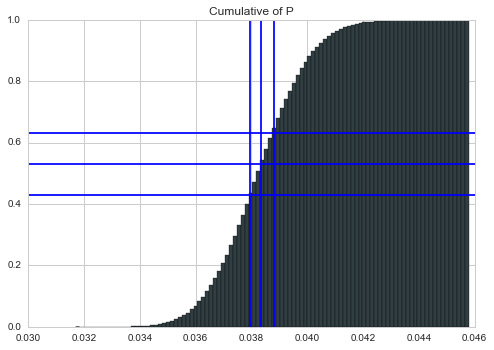

In [22]:
#cumulative plot of P
pl.hist(samples[:,1], 100, normed = 1,  cumulative = True)

pl.axvline(x = 0.038338727490507638)
pl.axhline(y = .43)
pl.axhline(y = .53)
pl.axhline(y = .63)

pl.axvline(x = .03794)
pl.axvline(x = .0388)
pl.title('Cumulative of P')
pl.show()



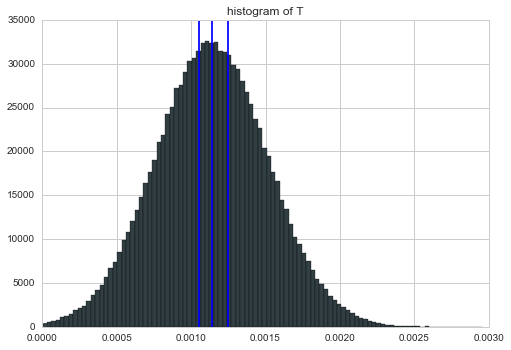

0.0011388790060408239

In [26]:
#histogram of T
pl.hist(samples[:,2], 100,)
pl.title('histogram of T')
pl.axvline(x = 0.0011369607841247027)

pl.axvline(x = .00105)
pl.axvline(x = .00125)
pl.show()
np.mean(samples[:,2])

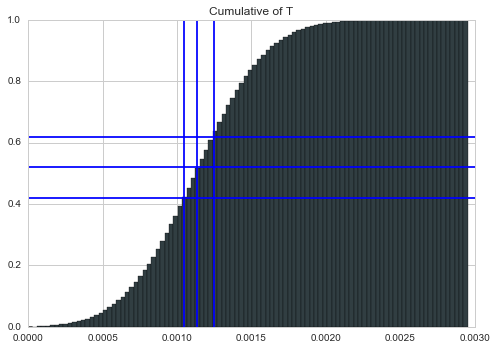

In [25]:
#cumulative plot of T
pl.hist(samples[:,2], 100, normed = 1,  cumulative = True)

pl.axvline(x = 0.0011369607841247027)
pl.axhline(y = .42)
pl.axhline(y = .52)
pl.axhline(y = .62)

pl.axvline(x = .00105)
pl.axvline(x = .00125)
pl.title('Cumulative of T')
pl.show()



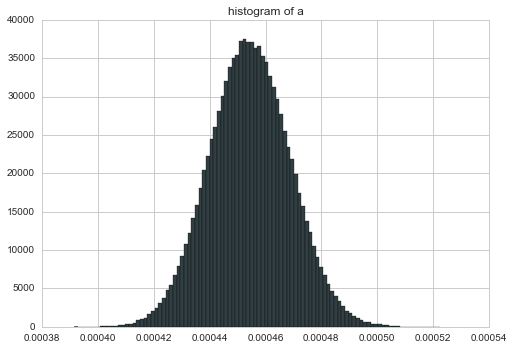

the mean is:  0.000454422920392


In [29]:
#histogram of a
pl.hist(samples[:,3], 100,)
pl.title('histogram of a')
#pl.axvline(x = -0.016625410219655516)
#pl.axvline(x = -.017)
#pl.axvline(x = -.0162)
pl.show()

print 'the mean is: ', np.mean(samples[:,3])

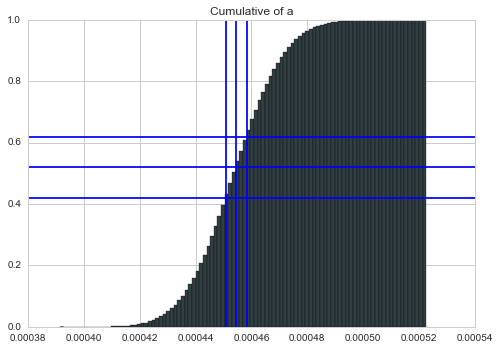

In [30]:
#cumulative plot of a
pl.hist(samples[:,3], 100, normed = 1,  cumulative = True)

pl.axvline(x = 0.00045453205031788354)
pl.axhline(y = .42)
pl.axhline(y = .52)
pl.axhline(y = .62)

pl.axvline(x = .000451)
pl.axvline(x = .0004585)
pl.title('Cumulative of a')
pl.show()



from this it can be derived that znot = -.016, q = 8.9884355587944622, p = 0.038338727490507638, T = 0.0011369607841247027, a = 0.00045453205031788354. 

The graph with these numbers superimposed with the data is shown below. 

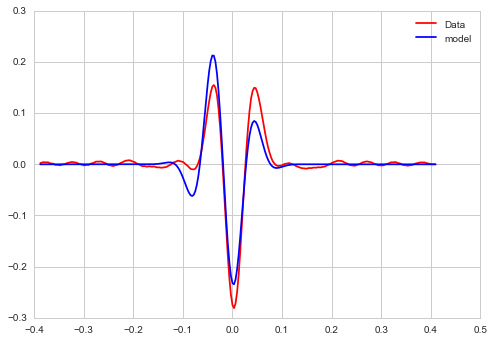

In [31]:
pl.plot(t, D, color = 'red', label = 'Data')
x, Modelf = psi1(8.9884355587944622, 0.038338727490507638, 0.0011369607841247027)
pl.plot(x, Modelf*0.00045453205031788354, color = 'blue', label = 'model')
pl.legend()
pl.show()
